In [1]:
%pylab inline
import numpy as np
import pylab as pl

Populating the interactive namespace from numpy and matplotlib


# Parameter selection, Validation & Testing

## Hyperparameters, Over-fitting, and Under-fitting

*The content in this section is adapted from Andrew Ng's excellent
Coursera course, available here:* https://www.coursera.org/course/ml

The issues associated with validation and 
cross-validation are some of the most important
aspects of the practice of machine learning.  Selecting the optimal model
for your data is vital, and is a piece of the problem that is not often
appreciated by machine learning practitioners.

Of core importance is the following question:

**If our estimator is underperforming, how should we move forward?**

- Use simpler or more complicated model?
- Add more features to each observed data point?
- Add more training samples?

The answer is often counter-intuitive.  In particular, **Sometimes using a
more complicated model will give _worse_ results.**  Also, **Sometimes adding
training data will not improve your results.**  The ability to determine
what steps will improve your model is what separates the successful machine
learning practitioners from the unsuccessful.

### Bias-variance trade-off: illustration on a simple regression problem

For this section, we'll work with a simple 1D regression problem.  This will help us to
easily visualize the data and the model, and the results generalize easily to  higher-dimensional
datasets.  We'll explore a simple **linear regression** problem.
This can be accomplished within scikit-learn with the `sklearn.linear_model` module.

We consider the situation where we have only 2 data points:

In [2]:
X = np.c_[ .5, 1].T
y = [.5, 1]
X_test = np.c_[ 0, 2].T

In [3]:
X

array([[0.5],
       [1. ]])

In [4]:
y

[0.5, 1]

In [5]:
X_test

array([[0],
       [2]])

/Users/rusty/.env/dev/lib/python2.7/site-packages/sklearn/linear_model/base.py:509: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


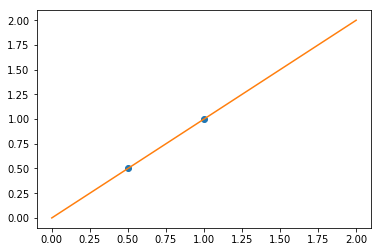

In [6]:
from sklearn import linear_model
regr = linear_model.LinearRegression()

regr.fit(X, y)
pl.plot(X, y, 'o')
pl.plot(X_test, regr.predict(X_test)) 

In real life situation, we have noise (e.g. measurement noise) in our data:

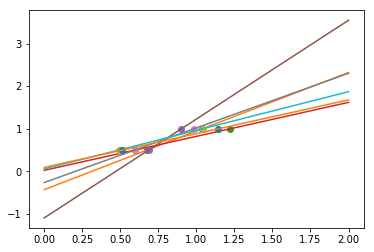

In [8]:
np.random.seed(0)
for _ in range(6):
    noise = np.random.normal(loc=0, scale=.1, size=X.shape)
    noisy_X = X + noise
    pl.plot(noisy_X, y, 'o')  
    regr.fit(noisy_X, y)
    pl.plot(X_test, regr.predict(X_test))

As we can see, our linear model captures and amplifies the noise in the data. It displays a lot of variance.

We can use another linear estimator that uses regularization, the `Ridge` estimator. This estimator regularizes the coefficients by shrinking them to zero, under the assumption that very high correlations are often spurious. The alpha parameter controls the amount of shrinkage used.

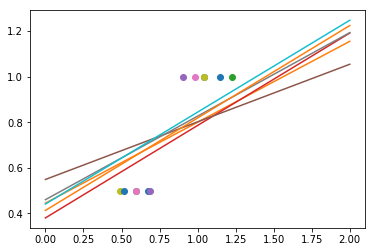

In [12]:
regr = linear_model.Ridge(alpha=0.19)
np.random.seed(0)
for _ in range(6):
    noise = np.random.normal(loc=0, scale=.1, size=X.shape)
    noisy_X = X + noise
    pl.plot(noisy_X, y, 'o')  
    regr.fit(noisy_X, y)
    pl.plot(X_test, regr.predict(X_test))

As we can see, the estimator displays much less variance. However it systematically under-estimates the coefficient. It displays a biased behavior.

This is a typical example of bias/variance tradeof: non-regularized estimator are not biased, but they can display a lot of bias. Highly-regularized models have little variance, but high bias. This bias is not necessarily a bad thing: it practice what matters is choosing the tradeoff between bias and variance that leads to the best prediction performance. For a specific dataset there is a sweet spot corresponding to the highest complexity that the data can support, depending on the amount of noise and of observations available.

## Learning Curves and the Bias/Variance Tradeoff

One way to address this issue is to use what are often called **Learning Curves**.
Given a particular dataset and a model we'd like to fit (e.g. a polynomial), we'd
like to tune our value of the *hyperparameter* `d` to give us the best fit.

We'll imagine we have a simple regression problem: given the size of a house, we'd
like to predict how much it's worth.  We'll fit it with our polynomial regression
model.

Run the following code to see an example plot:

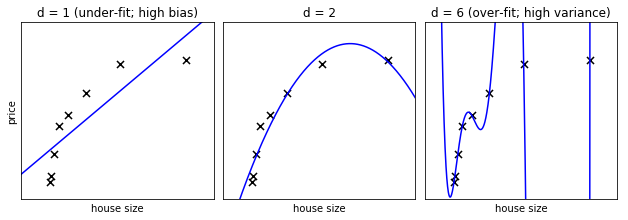

In [11]:
from figures import plot_bias_variance
plot_bias_variance(8, random_seed=42)

In the above figure, we see fits for three different values of `d`.
For `d = 1`, the data is under-fit. This means that the model is too
simplistic: no straight line will ever be a good fit to this data. In
this case, we say that the model suffers from high bias. The model
itself is biased, and this will be reflected in the fact that the data
is poorly fit. At the other extreme, for `d = 6` the data is over-fit.
This means that the model has too many free parameters (6 in this case)
which can be adjusted to perfectly fit the training data. If we add a
new point to this plot, though, chances are it will be very far from
the curve representing the degree-6 fit. In this case, we say that the
model suffers from high variance. The reason for the term "high variance" is that if
any of the input points are varied slightly, it could result in a very different model.

In the middle, for `d = 2`, we have found a good mid-point. It fits
the data fairly well, and does not suffer from the bias and variance
problems seen in the figures on either side. What we would like is a
way to quantitatively identify bias and variance, and optimize the
metaparameters (in this case, the polynomial degree d) in order to
determine the best algorithm. This can be done through a process
called *validation*.

### Validation Curves

We'll create a dataset like in the example above, and use this to test our
validation scheme.  First we'll define some utility routines:

In [11]:
def test_func(x, err=0.5):
    return np.random.normal(10 - 1. / (x + 0.1), err)

def compute_error(x, y, p):
    yfit = np.polyval(p, x)
    return np.sqrt(np.mean((y - yfit) ** 2))

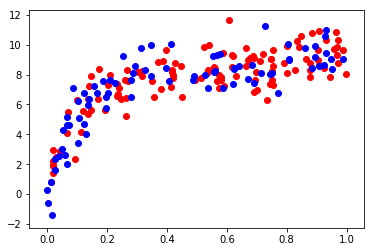

In [12]:
from sklearn.cross_validation import train_test_split

N = 200
test_size = 0.4
error = 1.0

# randomly sample the data
np.random.seed(1)
x = np.random.random(N)
y = test_func(x, error)

# split into training, validation, and testing sets.
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=test_size)

# show the training and validation sets
plt.scatter(xtrain, ytrain, color='red')
plt.scatter(xtest, ytest, color='blue')

In order to quantify the effects of bias and variance and construct
the best possible estimator, we will split our training data into
a *training set* and a *validation set*.  As a general rule, the
training set should be about 60% of the samples.

The overarching idea is as follows. The model parameters (in our case,
the coefficients of the polynomials) are learned using the training
set as above. The error is evaluated on the validation set,
and the meta-parameters (in our case, the degree of the polynomial)
are adjusted so that this validation error is minimized.
Finally, the labels are predicted for the test set. These labels
are used to evaluate how well the algorithm can be expected to
perform on unlabeled data.

The validation error of our polynomial classifier can be visualized
by plotting the error as a function of the polynomial degree d. We can do
this as follows:

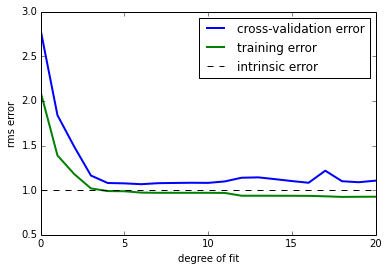

In [6]:
# suppress warnings from Polyfit
import warnings
warnings.filterwarnings('ignore', message='Polyfit*')

degrees = np.arange(21)
train_err = np.zeros(len(degrees))
validation_err = np.zeros(len(degrees))

for i, d in enumerate(degrees):
    p = np.polyfit(xtrain, ytrain, d)

    train_err[i] = compute_error(xtrain, ytrain, p)
    validation_err[i] = compute_error(xtest, ytest, p)

fig, ax = plt.subplots()

ax.plot(degrees, validation_err, lw=2, label = 'cross-validation error')
ax.plot(degrees, train_err, lw=2, label = 'training error')
ax.plot([0, 20], [error, error], '--k', label='intrinsic error')

ax.legend(loc=0)
ax.set_xlabel('degree of fit')
ax.set_ylabel('rms error')

This figure compactly shows the reason that validation is
important. On the left side of the plot, we have very low-degree
polynomial, which under-fits the data. This leads to a very high
error for both the training set and the validation set. On
the far right side of the plot, we have a very high degree
polynomial, which over-fits the data. This can be seen in the fact
that the training error is very low, while the validation
error is very high. Plotted for comparison is the intrinsic error
(this is the scatter artificially added to the data: click on the
above image to see the source code). For this toy dataset,
error = 1.0 is the best we can hope to attain. Choosing `d=6` in
this case gets us very close to the optimal error.

The astute reader will realize that something is amiss here: in
the above plot, `d = 6` gives the best results. But in the previous
plot, we found that `d = 6` vastly over-fits the data. What’s going
on here? The difference is the **number of training points** used.
In the previous example, there were only eight training points.
In this example, we have 100. As a general rule of thumb, the more
training points used, the more complicated model can be used.
But how can you determine for a given model whether more training
points will be helpful? A useful diagnostic for this are learning curves.

### Learning Curves

A learning curve is a plot of the training and validation
error as a function of the number of training points. Note that
when we train on a small subset of the training data, the training
error is computed using this subset, not the full training set.
These plots can give a quantitative view into how beneficial it
will be to add training samples.

In [13]:
# suppress warnings from Polyfit
import warnings
warnings.filterwarnings('ignore', message='Polyfit*')

def plot_learning_curve(d, N=200):
    n_sizes = 50
    n_runs = 10
    sizes = np.linspace(2, N, n_sizes).astype(int)
    train_err = np.zeros((n_runs, n_sizes))
    validation_err = np.zeros((n_runs, n_sizes))
    for i in range(n_runs):
        for j, size in enumerate(sizes):
            xtrain, xtest, ytrain, ytest = train_test_split(
                x, y, test_size=test_size, random_state=i)
            # Train on only the first `size` points
            p = np.polyfit(xtrain[:size], ytrain[:size], d)
            
            # Validation error is on the *entire* validation set
            validation_err[i, j] = compute_error(xtest, ytest, p)
            
            # Training error is on only the points used for training
            train_err[i, j] = compute_error(xtrain[:size], ytrain[:size], p)

    fig, ax = plt.subplots()
    ax.plot(sizes, validation_err.mean(axis=0), lw=2, label='mean validation error')
    ax.plot(sizes, train_err.mean(axis=0), lw=2, label='mean training error')
    ax.plot([0, N], [error, error], '--k', label='intrinsic error')

    ax.set_xlabel('traning set size')
    ax.set_ylabel('rms error')
    
    ax.legend(loc=0)
    
    ax.set_xlim(0, N-1)

    ax.set_title('d = %i' % d)

Now that we've defined this function, we can plot the learning curve.
But first, take a moment to think about what we're going to see:

**Questions:**

- **As the number of training samples are increased, what do you expect to see for the training error?  For the validation error?**
- **Would you expect the training error to be higher or lower than the validation error?  Would you ever expect this to change?**

We can run the following code to plot the learning curve for a ``d=1`` model:

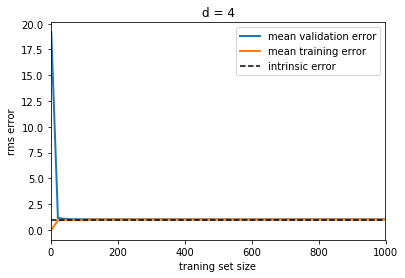

In [25]:
plot_learning_curve(d=4, N=1000 )

Notice that the validation error *generally decreases* with a growing training set,
while the training error *generally increases* with a growing training set.  From
this we can infer that as the training size increases, they will converge to a single
value.

From the above discussion, we know that `d = 1` is a high-bias estimator which
under-fits the data. This is indicated by the fact that both the
training and validation errors are very high. When confronted with this type of learning curve,
we can expect that adding more training data will not help matters: both
lines will converge to a relatively high error.

**When the learning curves have converged to a high error, we have a high bias model.**

A high-bias model can be improved by:

- Using a more sophisticated model (i.e. in this case, increase ``d``)
- Gather more features for each sample.
- Decrease regularlization in a regularized model.

A high-bias model cannot be improved, however, by increasing the number of training
samples (do yousee why?)

Now let's look at a high-variance (i.e. over-fit) model:

In [ ]:
plot_learning_curve(d=20, N=100)
plt.ylim(0, 15)

Here we show the learning curve for `d = 20`. From the above
discussion, we know that `d = 20` is a **high-variance** estimator
which **over-fits** the data. This is indicated by the fact that the
training error is much less than the validation error. As
we add more samples to this training set, the training error will
continue to climb, while the cross-validation error will continue
to decrease, until they meet in the middle. In this case, our
intrinsic error was set to 1.0, and we can infer that adding more
data will allow the estimator to very closely match the best
possible cross-validation error.

**When the learning curves have not yet converged with our full training set, it indicates a high-variance, over-fit model.**

A high-variance model can be improved by:

- Gathering more training samples.
- Using a less-sophisticated model (i.e. in this case, make ``d`` smaller)
- Increasing regularization.

In particular, gathering more features for each sample will not help the results.

## Summary

We’ve seen above that an under-performing algorithm can be due
to two possible situations: high bias (under-fitting) and high
variance (over-fitting). In order to evaluate our algorithm, we
set aside a portion of our training data for cross-validation.
Using the technique of learning curves, we can train on progressively
larger subsets of the data, evaluating the training error and
cross-validation error to determine whether our algorithm has
high variance or high bias. But what do we do with this information?

### High Bias

If our algorithm shows high **bias**, the following actions might help:

- **Add more features**. In our example of predicting home prices,
  it may be helpful to make use of information such as the neighborhood
  the house is in, the year the house was built, the size of the lot, etc.
  Adding these features to the training and test sets can improve
  a high-bias estimator
- **Use a more sophisticated model**. Adding complexity to the model can
  help improve on bias. For a polynomial fit, this can be accomplished
  by increasing the degree d. Each learning technique has its own
  methods of adding complexity.
- **Use fewer samples**. Though this will not improve the classification,
  a high-bias algorithm can attain nearly the same error with a smaller
  training sample. For algorithms which are computationally expensive,
  reducing the training sample size can lead to very large improvements
  in speed.
- **Decrease regularization**. Regularization is a technique used to impose
  simplicity in some machine learning models, by adding a penalty term that
  depends on the characteristics of the parameters. If a model has high bias,
  decreasing the effect of regularization can lead to better results.

### High Variance

If our algorithm shows **high variance**, the following actions might help:

- **Use fewer features**. Using a feature selection technique may be
  useful, and decrease the over-fitting of the estimator.
- **Use a simpler model**.  Model complexity and over-fitting go hand-in-hand.
- **Use more training samples**. Adding training samples can reduce
  the effect of over-fitting, and lead to improvements in a high
  variance estimator.
- **Increase Regularization**. Regularization is designed to prevent
  over-fitting. In a high-variance model, increasing regularization
  can lead to better results.

These choices become very important in real-world situations. For example,
due to limited telescope time, astronomers must seek a balance between
observing a large number of objects, and observing a large number of
features for each object. Determining which is more important for a
particular learning task can inform the observing strategy that the
astronomer employs. In a later exercise, we will explore the use of
learning curves for the photometric redshift problem.

### More Sophisticated Methods

There are a lot more options for performing validation and model testing.
In particular, there are several schemes for cross-validation, in which
the model is fit multiple times with different training and test sets.
The details are different, but the principles are the same as what we've
seen here.

For more information see the ``sklearn.cross_validation`` module documentation,
and the information on the scikit-learn website.

## One Last Caution

Using validation schemes to determine hyper-parameters means that we are
fitting the hyper-parameters to the particular validation set.  In the same
way that parameters can be over-fit to the training set, hyperparameters can
be over-fit to the validation set.  Because of this, the validation error
tends to under-predict the classification error of new data.

For this reason, it is recommended to split the data into three sets:

- The **training set**, used to train the model (usually ~60% of the data)
- The **validation set**, used to validate the model (usually ~20% of the data)
- The **test set**, used to evaluate the expected error of the validated model (usually ~20% of the data)

This may seem excessive, and many machine learning practitioners ignore the need
for a test set.  But if your goal is to predict the error of a model on unknown
data, using a test set is vital.